# ITC

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import signal, stats
import mat73
import re
from neurodsp.timefrequency import compute_wavelet_transform
import os
import mne
import IPython
import seaborn as sns
import scipy
import joblib
import h5io
import dask.array as da 

import statsmodels
from statsmodels import stats
from statsmodels.stats import multitest

# Import required code for visualizing example models
from neurodsp.utils import create_times
from neurodsp.plts.time_series import plot_time_series
from neurodsp.spectral import compute_spectrum, rotate_powerlaw
from neurodsp.plts.spectral import plot_power_spectra



In [2]:
## funcions

def compute_itc(epochs, freqs, n_cycles, workers = 8):
    """ function to compute TFR via Morlet wavelets
    
    epochs:                     MNE epoch object with channels of interest
    freqs:                      list of frequencies, should be log spaced
    n_cycles:                   number of cycles, adjust with freqs to balance temporal and frequency resolution
    baseline:                   tuple that specifies the time in seconds that baseline should be calculated on 
                                (should be 1-2s smaller than epoch TFR was calculated on to exclude artificats on morlet waves
    zscore:                     boolean, if True zscores within trial and frequency band across the time window specified in baseline
    workers:                    number of threads to use while calculating TFR
    """
    print('computing TFR')
    TFR, itc = mne.time_frequency.tfr_morlet(trial_onset_roi,freqs,n_cycles,return_itc=True,
                                            average=True,  n_jobs = 8)
    return itc


In [3]:
# Set frequencies

freqs = np.logspace(start = np.log10(1), stop = np.log10(150), num = 80, base = 10, endpoint = True)
n_cycles = np.logspace(np.log10(2), np.log10(30), base = 10, num = 80)

# formulas to check bandwidth and time bin
band_width = (freqs / n_cycles) * 2
time_bin = n_cycles / freqs / np.pi
print(freqs)
print(n_cycles)
print(time_bin)
print(band_width)

[  1.           1.06548039   1.13524845   1.20958496   1.28878905
   1.37317945   1.46309577   1.55889984   1.6609772    1.76973863
   1.8856218    2.00909304   2.14064922   2.28081976   2.43016872
   2.5892971    2.75884527   2.93949552   3.13197482   3.33705774
   3.55556956   3.78838962   4.03645484   4.30076345   4.5823791
   4.88243505   5.20213877   5.54277682   5.90571998   6.2924288
   6.70445946   7.14347005   7.61122722   8.10961331   8.64063391
   9.20642595   9.80926626  10.45158079  11.13595433  11.8651409
  12.6420749   13.46988283  14.35189595  15.29166362  16.29296764
  17.35983743  18.49656627  19.70772855  20.99819821  22.37316831
  23.83817199  25.39910467  27.06224782  28.83429423  30.72237491
  32.73408785  34.87752853  37.16132253  39.59466023  42.18733383
  44.94977669  47.89310538  51.02916436  54.37057369  57.93077979
  61.72410955  65.76582801  70.07219975  74.66055437  79.54935622
  84.75827869  90.30828341  96.22170458 102.52233885 109.23554107
 116.38832636

## SLCH002

In [4]:
## Prep paths ##

subject = 'SLCH002'
raw_data_dir = f"/home/brooke/pacman/raw_data/{subject}"
preproc_data_dir = f"/home/brooke/pacman/preprocessing/{subject}/ieeg"

In [5]:
## Load Neural Data

# load
trial_onset_epochs = mne.read_epochs(f"{preproc_data_dir}/{subject}_bp_clean_pres-locked_ieeg.fif")

# get good epochs (for behavioral data only)
good_epochs = [i for i,x in enumerate(trial_onset_epochs.get_annotations_per_epoch()) if not x]
bad_epochs = [i for i,x in enumerate(trial_onset_epochs.get_annotations_per_epoch()) if  x]

# onlt good epochs
trial_onset_epochs = trial_onset_epochs[good_epochs]

Reading /home/brooke/pacman/preprocessing/SLCH002/ieeg/SLCH002_bp_clean_pres-locked_ieeg.fif ...


/tmp/ipykernel_2020/973766942.py:4: RuntimeWarning: This filename (/home/brooke/pacman/preprocessing/SLCH002/ieeg/SLCH002_bp_clean_pres-locked_ieeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  trial_onset_epochs = mne.read_epochs(f"{preproc_data_dir}/{subject}_bp_clean_pres-locked_ieeg.fif")


    Found the data of interest:
        t =   -4000.00 ...   12000.00 ms
        0 CTF compensation matrices available
Reading /home/brooke/pacman/preprocessing/SLCH002/ieeg/SLCH002_bp_clean_pres-locked_ieeg-1.fif ...
    Found the data of interest:
        t =   -4000.00 ...   12000.00 ms
        0 CTF compensation matrices available
Reading /home/brooke/pacman/preprocessing/SLCH002/ieeg/SLCH002_bp_clean_pres-locked_ieeg-2.fif ...
    Found the data of interest:
        t =   -4000.00 ...   12000.00 ms
        0 CTF compensation matrices available
Not setting metadata
240 matching events found
No baseline correction applied
0 projection items activated


In [6]:
## Dictionary of electrode locations ##

# Dictionary mapping ROI to elecs
ROIs = {
    'hc'     :['K1', 'K2', 'K3', 'K4', 'K5', 'K6', 'J1', 'J2', 'J3', 'J4', 'J5', 'J6', 'K7'],
    'ofc'    :['A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'B5', 'B6', 'B7', 'B8', 'B9'],
    'amyg'   :['i1', 'i2', 'i3', 'i4', 'i5'],
    'insula' :['C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'E2', 'E3', 'E4', 'F1', 'F2', 'F3'],
    'cing'   :['A1', 'A2', 'A3', 'A4', 'B1', 'B2', 'B3', 'B4'],
    'ec'     :['H1', 'H2', 'H3', 'H4', 'L1', 'L2', 'L3', 'L4'], 
    'dlpfc'  :['C11', 'C12', 'C13', 'C14', 'C15', 'C16'] 
}

## prep lists

# primary ROI
hc_list = []
hc_indices = []
hc_names = []
ofc_list = []
ofc_indices = []
ofc_names = []
amyg_list = []
amyg_names = [] 
amyg_indices = []
cing_list = []
cing_names = [] 
cing_indices = []

# control ROI
insula_list = []
insula_names = []  
insula_indices = []
dlpfc_list = []
dlpfc_names = []  
dlpfc_indices = []
ec_list = []
ec_names = []  
ec_indices = []

# exclude bad ROI from list
pairs_long_name = [ch.split('-') for ch in trial_onset_epochs.info['ch_names']]
bidx = len(trial_onset_epochs.info['bads']) +1
pairs_name = pairs_long_name[bidx:len(pairs_long_name)]

# sort ROI into lists
for ix in range(0, len(pairs_name)):
    if pairs_name[ix][0] in ROIs['hc'] or pairs_name[ix][1] in ROIs['hc']:
        hc_list.append(trial_onset_epochs.info['ch_names'][ix + bidx])
        hc_names.append(pairs_name[ix])
        hc_indices.append(ix)
    if pairs_name[ix][0] in ROIs['ofc'] or pairs_name[ix][1] in ROIs['ofc']:
        ofc_list.append(trial_onset_epochs.info['ch_names'][ix + bidx])
        ofc_names.append(pairs_name[ix])
        ofc_indices.append(ix)
    if pairs_name[ix][0] in ROIs['amyg'] or pairs_name[ix][1] in ROIs['amyg']:
        amyg_list.append(trial_onset_epochs.info['ch_names'][ix + bidx])       
        amyg_names.append(pairs_name[ix])
        amyg_indices.append(ix)
    if pairs_name[ix][0] in ROIs['cing'] or pairs_name[ix][1] in ROIs['cing']:
        cing_list.append(trial_onset_epochs.info['ch_names'][ix + bidx])       
        cing_names.append(pairs_name[ix])
        cing_indices.append(ix)
        
    # control roi
    if pairs_name[ix][0] in ROIs['insula'] or pairs_name[ix][1] in ROIs['insula']:
        insula_list.append(trial_onset_epochs.info['ch_names'][ix + bidx])       
        insula_names.append(pairs_name[ix])
        insula_indices.append(ix)
    if pairs_name[ix][0] in ROIs['dlpfc'] or pairs_name[ix][1] in ROIs['dlpfc']:
        dlpfc_list.append(trial_onset_epochs.info['ch_names'][ix + bidx])       
        dlpfc_names.append(pairs_name[ix])
        dlpfc_indices.append(ix)
    if pairs_name[ix][0] in ROIs['ec'] or pairs_name[ix][1] in ROIs['ec']:
        ec_list.append(trial_onset_epochs.info['ch_names'][ix + bidx])       
        ec_names.append(pairs_name[ix])
        ec_indices.append(ix)        
        

### Hippocampus

In [7]:
hc_list

['J4-J5',
 'J5-J6',
 'J6-J7',
 'K1-K2',
 'K2-K3',
 'K3-K4',
 'K4-K5',
 'K5-K6',
 'K6-K7',
 'K7-K8']

In [8]:
# only ROI of interest
trial_onset_roi = trial_onset_epochs.copy().pick_channels(hc_list)


In [9]:
# Resample to 1000 
if trial_onset_roi.info['sfreq'] > 1000:
    trial_onset_roi= trial_onset_roi.resample(1000)

In [10]:
# compute TRF

roi_itc = []
roi_itc = compute_itc(trial_onset_roi,freqs,n_cycles)


computing TFR


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:  1.6min remaining:  1.1min
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:  2.9min finished


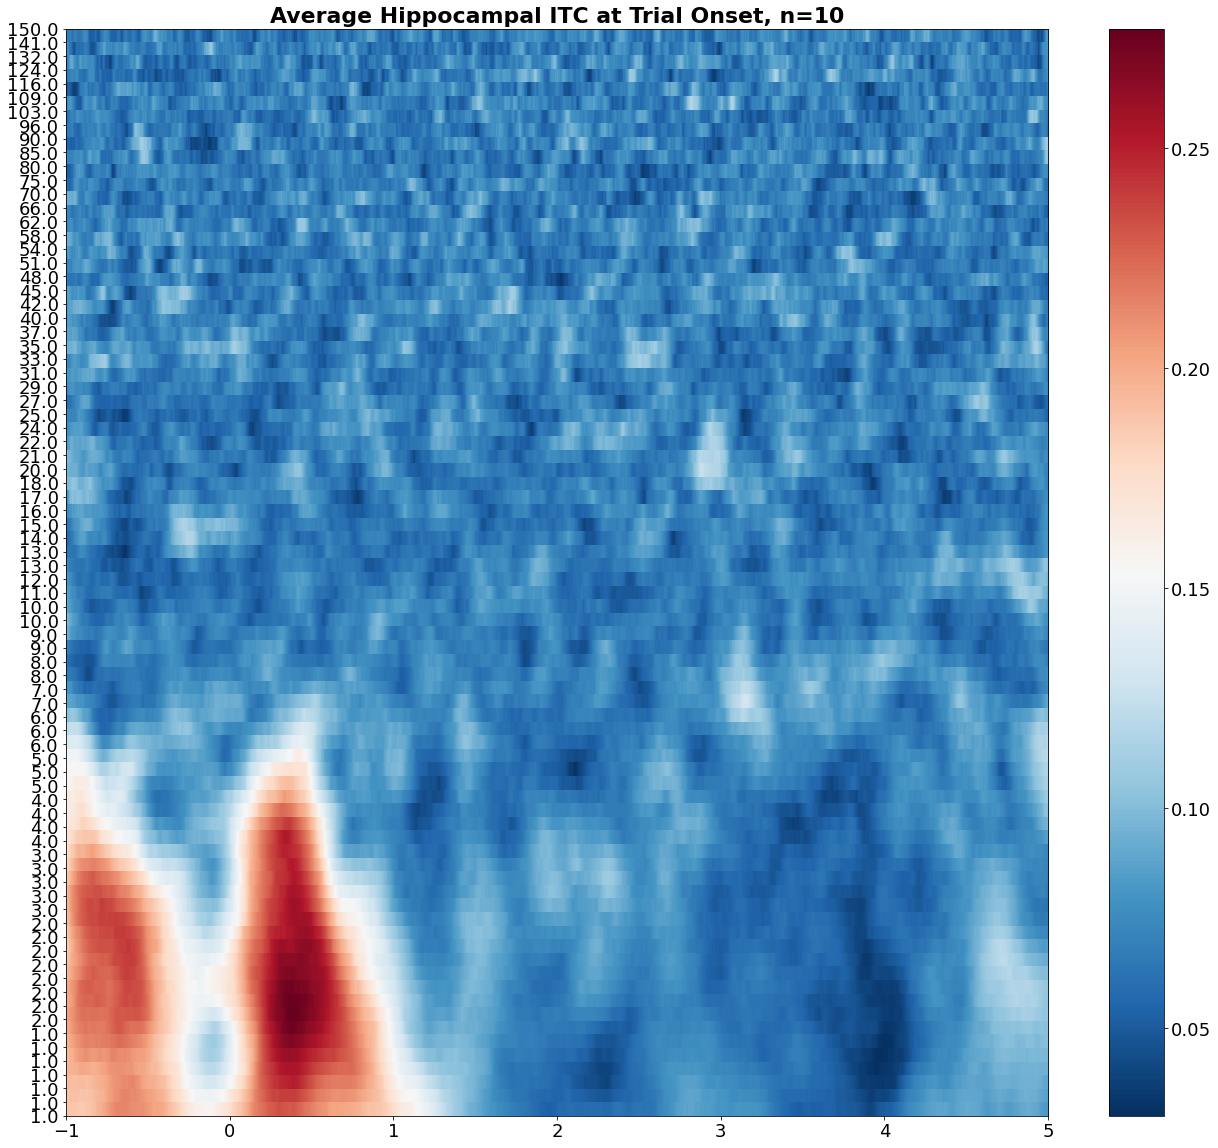

In [13]:
plt.rcParams['figure.figsize'] = [22, 20]
plt.rcParams.update({'font.size': 18})


fig, ax = plt.subplots(figsize = (22, 20))
i = ax.imshow(roi_itc.data[:, :, 3000:9000].mean(axis = 0), cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-1, 5, freqs[0], freqs[-1]])
ax.set_yticks(np.linspace(np.min(freqs),np.max(freqs),len(freqs)))
ax.set_yticklabels(np.round(freqs))
bar = plt.colorbar(i)
ax.set_title(f"Average Hippocampal ITC at Trial Onset, n={len(hc_list)}", fontsize=22, fontweight = 'bold')
fig.savefig(f'itc/{subject}_itc_hc_trialonset.png', dpi=600)
fig.show()


### OFC

In [14]:
ofc_list

['A5-A6',
 'A6-A7',
 'A7-A8',
 'A8-A9',
 'A9-A10',
 'A10-A11',
 'A11-A12',
 'B4-B5',
 'B5-B6',
 'B6-B7',
 'B7-B8',
 'B8-B9',
 'B9-B10']

In [15]:
# only roi of interest
trial_onset_roi = trial_onset_epochs.copy().pick_channels(ofc_list)


In [16]:
# Resample to 1000 
if trial_onset_roi.info['sfreq'] > 1000:
    trial_onset_roi= trial_onset_roi.resample(1000)

In [17]:
# compute TRF

roi_itc = []
roi_itc = compute_itc(trial_onset_roi,freqs,n_cycles)


computing TFR


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   9 out of  13 | elapsed:  3.1min remaining:  1.4min
[Parallel(n_jobs=8)]: Done  13 out of  13 | elapsed:  3.1min finished


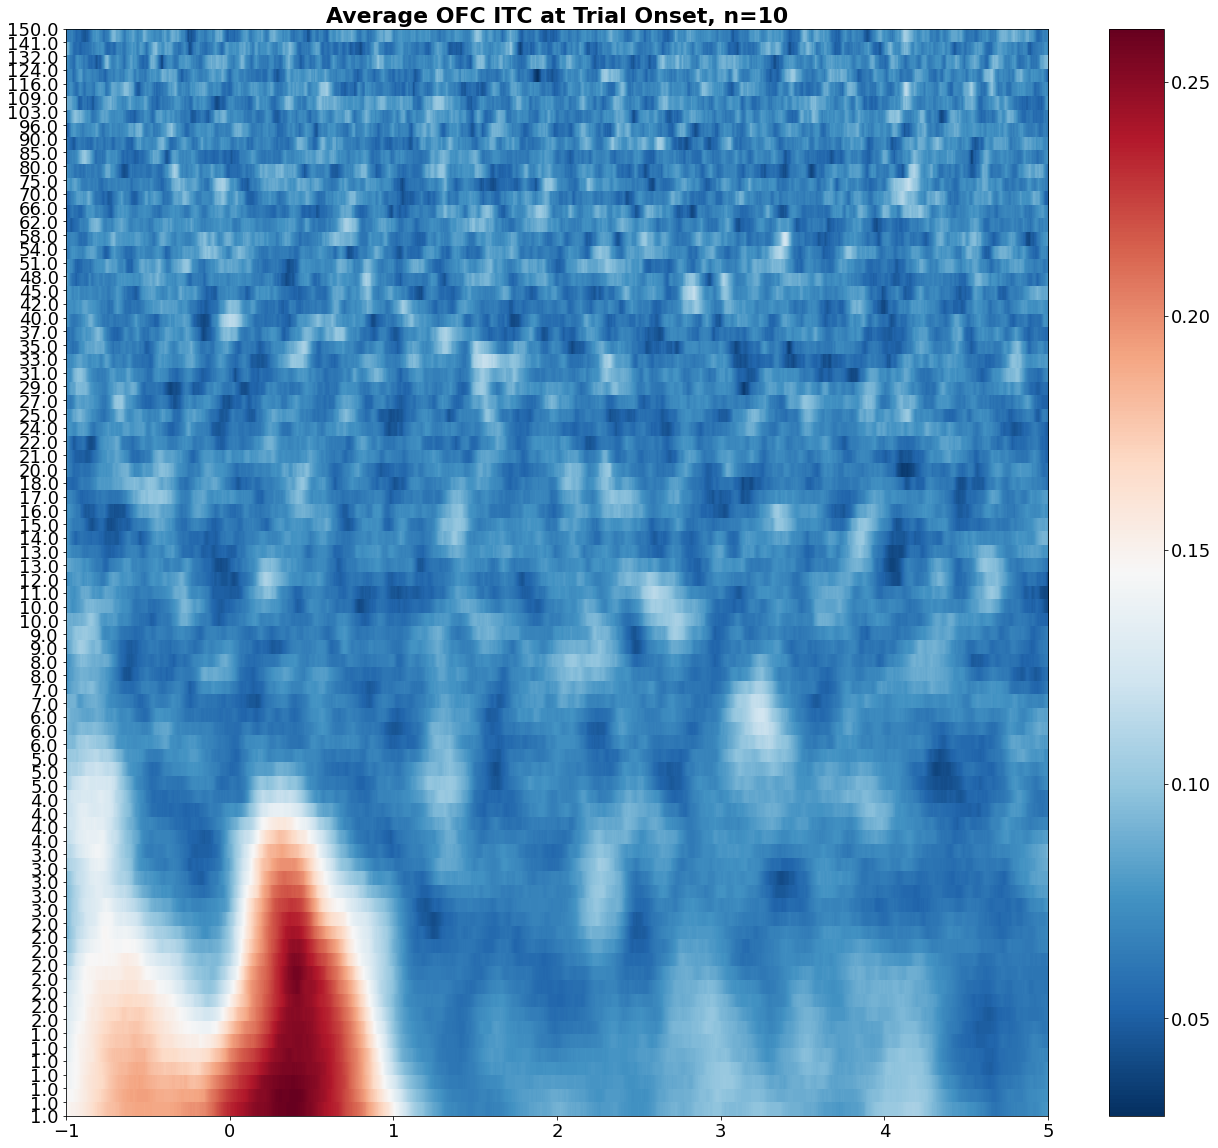

In [18]:
plt.rcParams['figure.figsize'] = [22, 20]
plt.rcParams.update({'font.size': 18})


fig, ax = plt.subplots(figsize = (22, 20))
i = ax.imshow(roi_itc.data[:, :, 3000:9000].mean(axis = 0), cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-1, 5, freqs[0], freqs[-1]])
ax.set_yticks(np.linspace(np.min(freqs),np.max(freqs),len(freqs)))
ax.set_yticklabels(np.round(freqs))
bar = plt.colorbar(i)
ax.set_title(f"Average OFC ITC at Trial Onset, n={len(hc_list)}", fontsize=22, fontweight = 'bold')
fig.savefig(f'itc/{subject}_itc_ofc_trialonset.png', dpi=600)
fig.show()


### Amygdala

In [19]:
amyg_list

['i1-i2', 'i2-i3', 'i3-i6']

In [20]:
# only roi 
trial_onset_roi = trial_onset_epochs.copy().pick_channels(amyg_list)


In [21]:
# Resample to 1000 
if trial_onset_roi.info['sfreq'] > 1000:
    trial_onset_roi= trial_onset_roi.resample(1000)

In [23]:
# compute TRF

roi_itc = []
roi_itc = compute_itc(trial_onset_roi,freqs,n_cycles)


computing TFR


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   3 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   3 out of   3 | elapsed:  1.3min finished


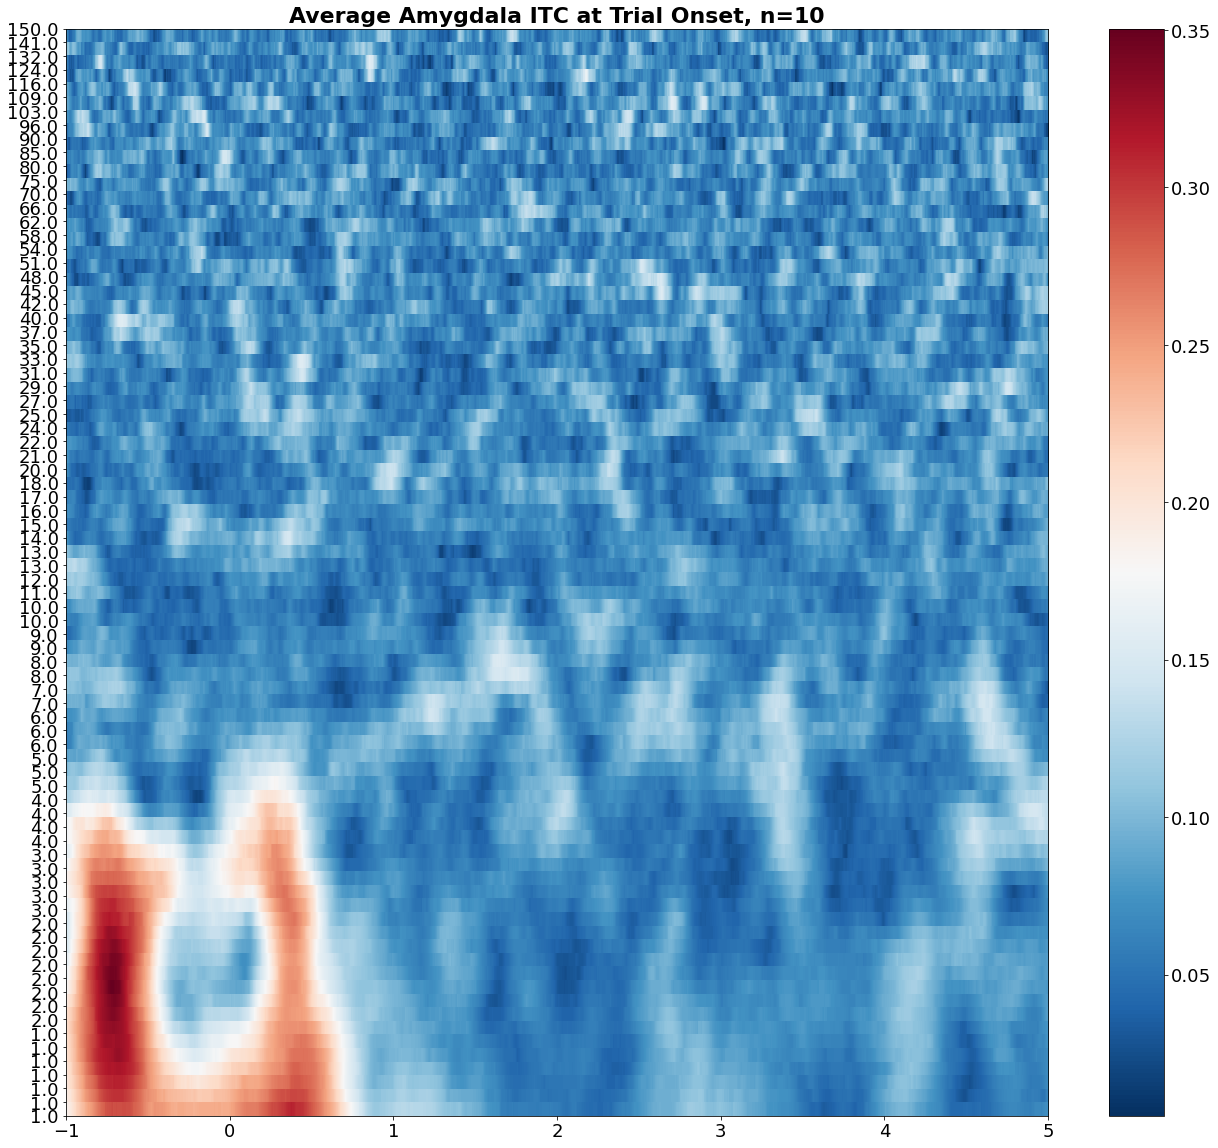

In [24]:
plt.rcParams['figure.figsize'] = [22, 20]
plt.rcParams.update({'font.size': 18})


fig, ax = plt.subplots(figsize = (22, 20))
i = ax.imshow(roi_itc.data[:, :, 3000:9000].mean(axis = 0), cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-1, 5, freqs[0], freqs[-1]])
ax.set_yticks(np.linspace(np.min(freqs),np.max(freqs),len(freqs)))
ax.set_yticklabels(np.round(freqs))
bar = plt.colorbar(i)
ax.set_title(f"Average Amygdala ITC at Trial Onset, n={len(hc_list)}", fontsize=22, fontweight = 'bold')
fig.savefig(f'itc/{subject}_itc_amyg_trialonset.png', dpi=600)
fig.show()


### Cingulate

In [25]:
cing_list

['A1-A2', 'A2-A3', 'A3-A4', 'A4-A5', 'B1-B2', 'B2-B3', 'B3-B4', 'B4-B5']

In [26]:
# only roi 
trial_onset_roi = trial_onset_epochs.copy().pick_channels(cing_list)


In [27]:
# Resample to 1000 
if trial_onset_roi.info['sfreq'] > 1000:
    trial_onset_roi= trial_onset_roi.resample(1000)

In [28]:
# compute TRF

roi_itc = []
roi_itc = compute_itc(trial_onset_roi,freqs,n_cycles)


computing TFR


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  2.0min remaining:  3.4min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.0min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.1min finished


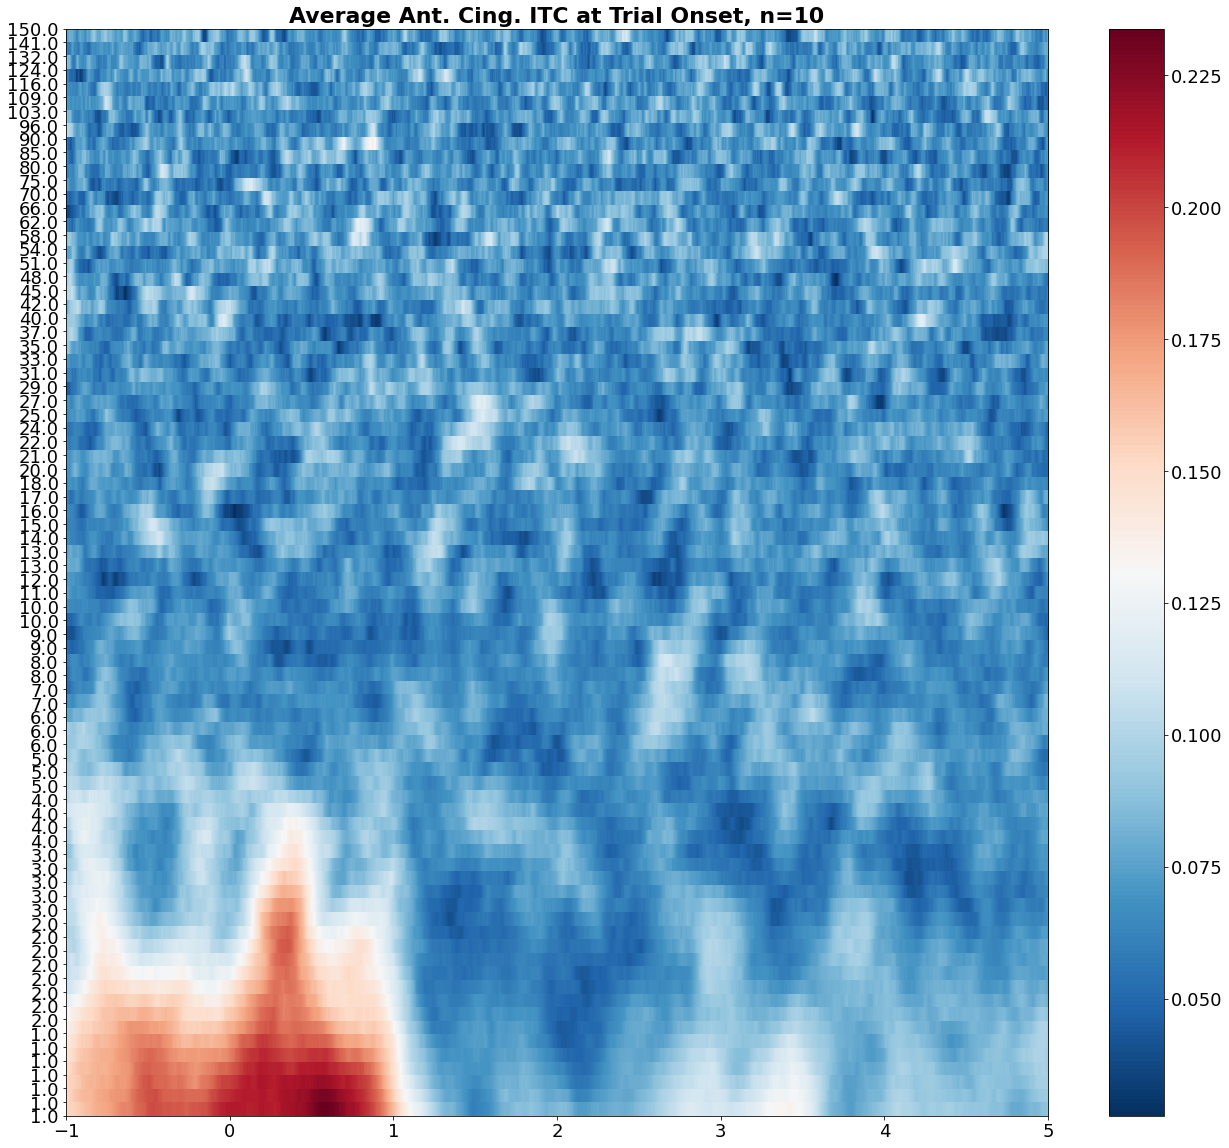

In [29]:
plt.rcParams['figure.figsize'] = [22, 20]
plt.rcParams.update({'font.size': 18})


fig, ax = plt.subplots(figsize = (22, 20))
i = ax.imshow(roi_itc.data[:, :, 3000:9000].mean(axis = 0), cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-1, 5, freqs[0], freqs[-1]])
ax.set_yticks(np.linspace(np.min(freqs),np.max(freqs),len(freqs)))
ax.set_yticklabels(np.round(freqs))
bar = plt.colorbar(i)
ax.set_title(f"Average Ant. Cing. ITC at Trial Onset, n={len(hc_list)}", fontsize=22, fontweight = 'bold')
fig.savefig(f'itc/{subject}_itc_cing_trialonset.png', dpi=600)
fig.show()


### Insula

In [30]:
insula_list

['C2-C3',
 'C3-C4',
 'C4-C5',
 'C5-C6',
 'C6-C7',
 'C7-C8',
 'C8-C9',
 'E1-E2',
 'E2-E3',
 'E3-E4',
 'E4-E5',
 'F1-F2',
 'F2-F3',
 'F3-F4']

In [31]:
# Only ROI
trial_onset_roi = trial_onset_epochs.copy().pick_channels(insula_list)


In [32]:
# Resample to 1000 
if trial_onset_roi.info['sfreq'] > 1000:
    trial_onset_roi= trial_onset_roi.resample(1000)

In [33]:
# compute TRF

roi_itc = []
roi_itc = compute_itc(trial_onset_roi,freqs,n_cycles)


computing TFR


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 out of  14 | elapsed:  4.1min remaining:  1.6min
[Parallel(n_jobs=8)]: Done  14 out of  14 | elapsed:  4.1min finished


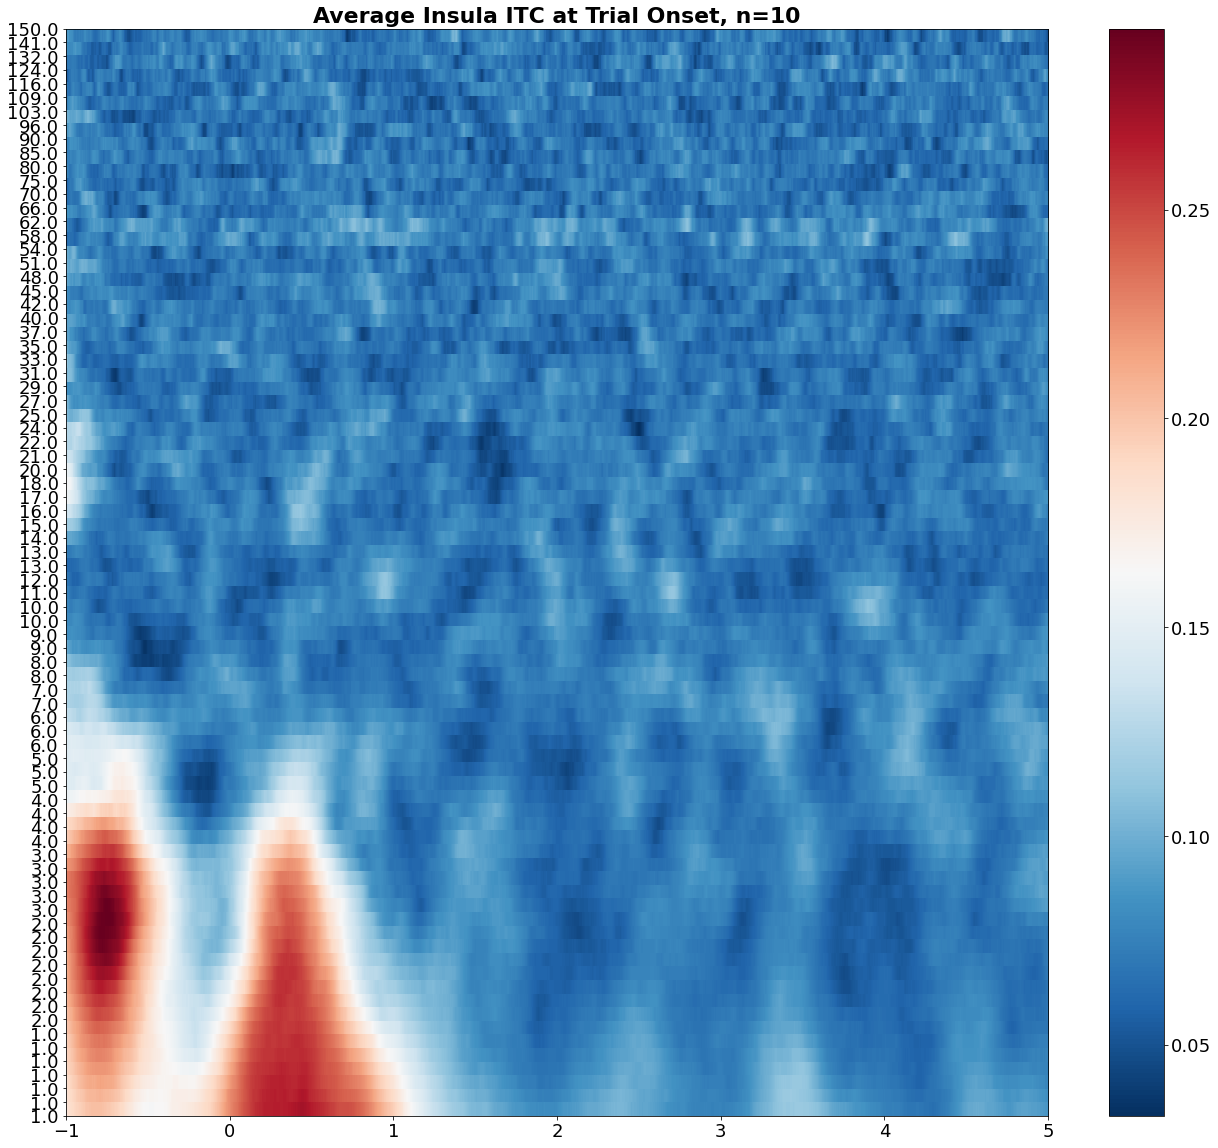

In [34]:
plt.rcParams['figure.figsize'] = [22, 20]
plt.rcParams.update({'font.size': 18})


fig, ax = plt.subplots(figsize = (22, 20))
i = ax.imshow(roi_itc.data[:, :, 3000:9000].mean(axis = 0), cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-1, 5, freqs[0], freqs[-1]])
ax.set_yticks(np.linspace(np.min(freqs),np.max(freqs),len(freqs)))
ax.set_yticklabels(np.round(freqs))
bar = plt.colorbar(i)
ax.set_title(f"Average Insula ITC at Trial Onset, n={len(hc_list)}", fontsize=22, fontweight = 'bold')
fig.savefig(f'itc/{subject}_itc_insula_trialonset.png', dpi=600)
fig.show()


### dlPFC

In [35]:
dlpfc_list

['C10-C11', 'C11-C12', 'C12-C13', 'C13-C14', 'C14-C15', 'C15-C16']

In [36]:
# Only ROI
trial_onset_roi = trial_onset_epochs.copy().pick_channels(dlpfc_list)


In [37]:
# Resample to 1000 
if trial_onset_roi.info['sfreq'] > 1000:
    trial_onset_roi= trial_onset_roi.resample(1000)

In [38]:
# compute TRF

roi_itc = []
roi_itc = compute_itc(trial_onset_roi,freqs,n_cycles)


computing TFR


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   6 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   6 out of   6 | elapsed:  1.9min finished


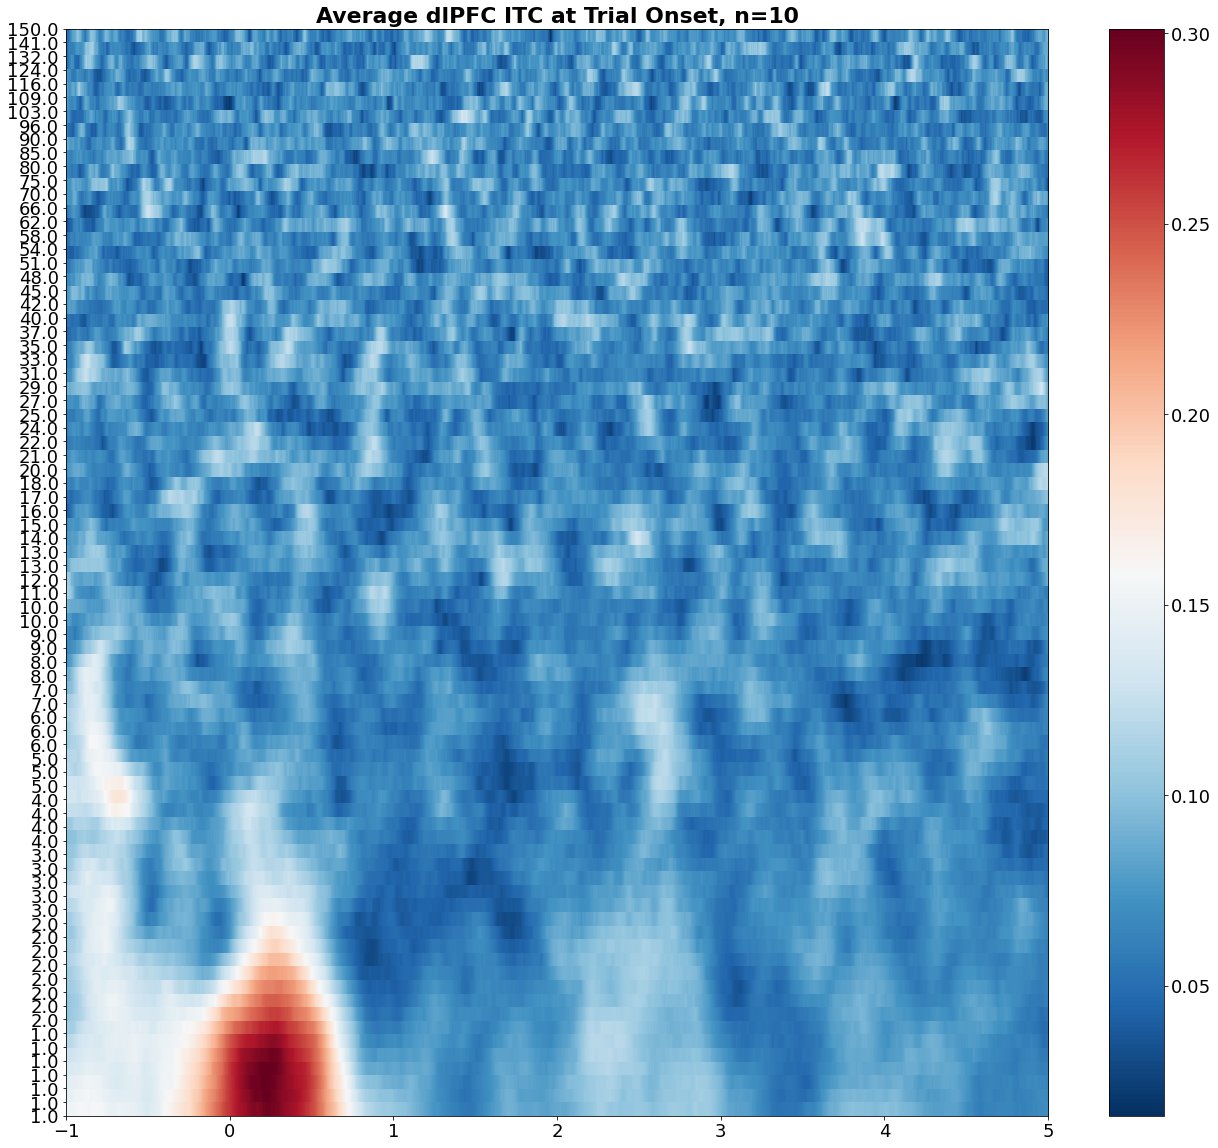

In [39]:
plt.rcParams['figure.figsize'] = [22, 20]
plt.rcParams.update({'font.size': 18})


fig, ax = plt.subplots(figsize = (22, 20))
i = ax.imshow(roi_itc.data[:, :, 3000:9000].mean(axis = 0), cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-1, 5, freqs[0], freqs[-1]])
ax.set_yticks(np.linspace(np.min(freqs),np.max(freqs),len(freqs)))
ax.set_yticklabels(np.round(freqs))
bar = plt.colorbar(i)
ax.set_title(f"Average dlPFC ITC at Trial Onset, n={len(hc_list)}", fontsize=22, fontweight = 'bold')
fig.savefig(f'itc/{subject}_itc_dlPFC_trialonset.png', dpi=600)
fig.show()
